In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

In [2]:
# Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y_true), axis=-1))
    
class InputTransformedKernel(tfp.math.psd_kernels.PositiveSemidefiniteKernel):

    def __init__(self, kernel, transformation, name='InputTransformedKernel'):
        self._kernel = kernel
        self._transformation = transformation
        super(InputTransformedKernel, self).__init__(
            feature_ndims=kernel.feature_ndims,
            dtype=kernel.dtype,
            name=name)

    def apply(self, x1, x2):
        return self._kernel.apply(
            self._transformation(x1),
            self._transformation(x2))

    def matrix(self, x1, x2):
        return self._kernel.matrix(
            self._transformation(x1),
            self._transformation(x2))

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor

class InputScaledKernel(InputTransformedKernel):

    def __init__(self, kernel, length_scales):
        super(InputScaledKernel, self).__init__(
            kernel,
            lambda x: x / tf.expand_dims(length_scales,
                                     -(kernel.feature_ndims + 1)))        

In [315]:
# Load labeled data
data = np.loadtxt('../data/labeled_data.dat')
x_labeled = data[:, :2].astype(np.float64) # -2 because we do not need porosity predictions
y_labeled = data[:, -3:-1].astype(np.float64) # dimensionless bond length and porosity measurements

# Normalize the data.
from sklearn import preprocessing

# normalize dataset with MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
x_labeled = scaler.fit_transform(x_labeled)
# y_labeled = scaler.fit_transform(y_labeled)

tr_size = 20

# train and test data
trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]
testX, testY = x_labeled[tr_size:,:], y_labeled[tr_size:]

trainY = np.transpose(trainY)
testY = np.transpose(testY)



data_phyloss = np.loadtxt('../data/unlabeled_data_BK_constw_v2_1525.dat')
x_unlabeled = data_phyloss[:, :]

# initial porosity
initporo = x_unlabeled[:, -1]

x_unlabeled1 = x_unlabeled[:1303, :2]
x_unlabeled2 = x_unlabeled[-6:, :2]
x_unlabeled = np.vstack((x_unlabeled1,x_unlabeled2))

x_unlabeled = scaler.fit_transform(x_unlabeled)
init_poro1 = initporo[:1303]
init_poro2 = initporo[-6:]
init_poro = np.hstack((init_poro1,init_poro2))

In [ ]:
import matplotlib.pyplot as plt
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [316]:
def build_gp(amplitude, length_scale):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)    
    se_kernel = tfk.ExponentiatedQuadratic(amplitude)  # length_scale = None here, implicitly

    # This is the "ARD" kernel (we don't like abbreviations or bizarrely obscure names in
    # TFP, so we're probably going to call this "InputScaledKernel" since....that's what it is! :)
    kernel = InputScaledKernel(se_kernel, length_scale)
    
    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(kernel=kernel,index_points=trainX)

gp_joint_model = tfd.JointDistributionNamedAutoBatched({
    'amplitude': tfd.TransformedDistribution(
            distribution=tfd.Normal(loc=0., scale=np.float64(1.)),
            bijector=tfb.Exp(),
            batch_shape=[2]),
    'length_scale': tfd.TransformedDistribution(
            distribution=tfd.Normal(loc=0., scale=np.float64(1.)),
            bijector=tfb.Exp(),
            batch_shape=[2,2]),
    'observations': build_gp,
})

In [317]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=np.random.uniform(size=2),
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=np.random.uniform(size=[2,2]),
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var]]

In [318]:
def strength(bl, porof, nlayer=6):
    sigma01, sigma02, C1s = 6, 31, 21
    sigma_long = sigma01*(tf.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
    n = tf.shape(sigma_long)[0]  
    sorted_strength, sortedIndices = tf.math.top_k(sigma_long, n, True)
    sorted_bl = tf.gather(bl, sortedIndices)
    sorted_porof = tf.gather(porof, sortedIndices)
    argg = tf.argsort(sorted_bl,axis=-1,direction='DESCENDING',stable=False,name=None)
    sorted_bl_corr = tf.gather(sorted_bl, argg)
    return sorted_bl_corr-sorted_bl

# @tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, poroi, lam):
    se_kernel = tfk.ExponentiatedQuadratic(amplitude)  # length_scale = None here, implicitly
    optimized_kernel = InputScaledKernel(se_kernel, length_scale)
    gprm = tfd.GaussianProcessRegressionModel(kernel=optimized_kernel, index_points = x_unlabeled)
    samples = gprm.sample(1)
    pred = tf.squeeze(samples, axis=0)

    phyloss_bl = tf.math.reduce_mean(tf.add(tf.nn.relu(tf.negative(pred[0,:])), tf.nn.relu(pred[0,:]-1.0)))
    phyloss_poro = tf.math.reduce_mean(tf.nn.relu(tf.negative(pred[1,:])))
    phyloss_stg = tf.math.reduce_mean(tf.nn.relu(strength(pred[0,:],pred[1,:])))
    
#     print("phyloss_bl:",-lam*tf.math.log(phyloss_bl))
#     print("phyloss_poro:",-lam*tf.math.log(phyloss_poro))
#     print("phyloss_stg:",-lam*tf.math.log(phyloss_stg))
    
#     print("phyloss_bl:",-lam*phyloss_bl)
#     print("phyloss_poro:",-lam*phyloss_poro)
#     print("phyloss_stg:",-lam*phyloss_stg)

#     normal_loss = gp_joint_model.log_prob({
#       'amplitude': amplitude,
#       'length_scale': length_scale,
#       'observations': trainY
#     })
#     print(normal_loss)
    
#     return - gp_joint_model.log_prob({
#       'amplitude': amplitude,
#       'length_scale': length_scale,
#       'observations': trainY
#   })

    return lam*phyloss_poro + lam*phyloss_bl + lam*phyloss_stg - gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observations': trainY
  })

In [319]:
tf.random.set_seed(1234)

# Optimize the model parameters.
num_iters = 20
lam = 50
optimizer = tf.optimizers.Adam(learning_rate=.5)

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)

for i in range(num_iters):
    with tf.GradientTape() as tape:
        loss = target_log_prob(amplitude_var, length_scale_var, init_poro, lam) # physics loss & normal loss


    print(i,"loss_inloop:",loss)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))

0 loss_inloop: tf.Tensor(2727.1233237189017, shape=(), dtype=float64)
1 loss_inloop: tf.Tensor(2404.1880092164224, shape=(), dtype=float64)
2 loss_inloop: tf.Tensor(2390.400281877266, shape=(), dtype=float64)
3 loss_inloop: tf.Tensor(2415.6091424533524, shape=(), dtype=float64)
4 loss_inloop: tf.Tensor(2426.9730502107172, shape=(), dtype=float64)
5 loss_inloop: tf.Tensor(2466.2544738934075, shape=(), dtype=float64)
6 loss_inloop: tf.Tensor(2438.667294818929, shape=(), dtype=float64)
7 loss_inloop: tf.Tensor(2443.215848010213, shape=(), dtype=float64)
8 loss_inloop: tf.Tensor(2434.461212923138, shape=(), dtype=float64)
9 loss_inloop: tf.Tensor(2430.1176314161758, shape=(), dtype=float64)
10 loss_inloop: tf.Tensor(2422.8175564474104, shape=(), dtype=float64)
11 loss_inloop: tf.Tensor(2415.1306364958446, shape=(), dtype=float64)
12 loss_inloop: tf.Tensor(2408.4102307864277, shape=(), dtype=float64)
13 loss_inloop: tf.Tensor(2409.3346576361428, shape=(), dtype=float64)
14 loss_inloop: tf.T

In [320]:
tf.random.set_seed(1234)
se_kernel = tfk.ExponentiatedQuadratic(amplitude_var)  # length_scale = None here, implicitly
optimized_kernel = InputScaledKernel(se_kernel, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(kernel=optimized_kernel, index_points = testX)
samples = gprm.sample(1)
# optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
# gpr = tfd.GaussianProcessRegressionModel(kernel=optimized_kernel, index_points = testX)
# samples = gpr.sample(1)
samples

<tf.Tensor: shape=(1, 2, 19), dtype=float64, numpy=
array([[[-0.3966425 , -0.39788673,  0.14211638,  0.37420326,
          0.2713158 ,  0.31421396,  0.02456335,  0.37300804,
         -0.04841087,  0.17304148,  0.2717261 ,  0.21265745,
          0.12872789, -0.52246511, -0.06778533,  0.31569271,
         -0.20717214, -0.39835725, -0.01768901],
        [ 0.00187297,  0.00394205, -0.01088301, -0.01502497,
          0.02339138, -0.01190745, -0.03384406, -0.01444801,
         -0.01284252, -0.03081804,  0.02476371, -0.00645626,
         -0.02080321,  0.0016247 ,  0.02613836, -0.01050925,
         -0.01198196,  0.00348179, -0.01628183]]])>

In [321]:
testY

array([[0.79380528, 0.8001183 , 0.60764034, 0.67563337, 0.83399752,
        0.81563049, 0.8417252 , 0.69016454, 0.79621823, 0.86163991,
        0.83187633, 0.71732518, 0.80834532, 0.63562038, 0.88989955,
        0.85033215, 0.84119739, 0.80844488, 0.7526181 ],
       [0.01666471, 0.01358868, 0.05432798, 0.03850274, 0.01010751,
        0.01129286, 0.009357  , 0.03579652, 0.01614062, 0.00770211,
        0.0105933 , 0.03315482, 0.01352198, 0.05269549, 0.00490424,
        0.00895544, 0.01003564, 0.01345683, 0.02496436]])

In [322]:
root_mean_squared_error(testY, samples)

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.80809113, 0.03519158]])>

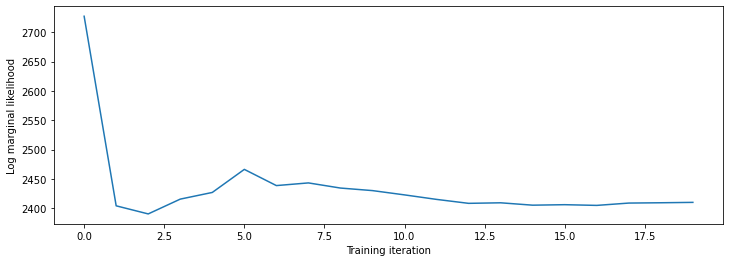

In [323]:
import matplotlib.pyplot as plt
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()